# (2) 고객 군집 분석 | 광고 프로모션 효율 증진을 위한 커머스 고객 세분화 | 파이썬 머신러닝

데이터의 차원(컬럼)이 많을 수록 고객을 분류할 기준을 찾기가 복잡해진다. 사람의 머리로는 4차원 이상의 데이터는 상상하기 어렵고 시각화 차트로 분포를 확인할 수도 없다. 이런 상황에서 머신러닝은 차원 수가 많더라도 그들 관계에 대한 가장 설명력이 높은 최적의 패턴을 찾아내는데, X와 Y를 연결하는 복잡한 식을 찾아낼 때도 사용되지만 X라는 집단을 x_a, x_b, x_c 등으로 세분화하는 임의의 기준을 발견하기 위해서도 사용된다. 후자를 군집 분석이라 하며 대표적으로 K-means 알고리즘이 다양한 분야에서 활용된다.

이번 장에서는 고객을 2개 그룹으로 분류해보면서 사람이 임의로 기준을 나누는 것과 머신러닝을 사용하는 방식의 차이를 살펴볼 것이다.

```
목차
___
Step 2. 고객 그룹 세분화
     1-1. 나이에 따라 분류하기
     1-2. 최근 구매일자에 따라 분류하기
     1-3. 가입 기간에 따라 분류하기
     1-4. 온/오프라인 선호도에 따라 분류하기
     1-5. 프로모션 동의 여부에 따라 분류하기
     1-6. 머신러닝으로 분류하기
```

## Step 2. 고객 그룹 세분화

[Step 1](https://songseungwon.tistory.com/entry/광고-프로모션-효율-증진을-위한-커머스-고객-세분화-Step-1-문제-상황-가정-및-데이터-전처리)에서 군집 분석에 들어가기 전, 현실 상황을 가정하기 위해 일부 컬럼을 제거하고 age컬럼의 이상치를 조정하는 등 필요한 전처리를 끝냈다. 이번 Step 2에서는 고객을 다양한 방식으로 세분화할 예정이며 이를 위해 필요한 파이썬 라이브러리와 이전 장에서 저장한 데이터를 다시 불러온다.

In [3]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

In [4]:
customer_df = pd.read_csv('./data/customer.csv')

customer_df

,id,day_f_buy,buy_f_promo,buy_f_web,buy_f_catalog,buy_f_store,visit_web,promo3,promo4,promo5,promo1,promo2,complain,promo6,age,period
0,5524,58,3,8,10,4,7,0,0,0,0,0,0,1,59,1042
1,2174,38,2,1,1,2,5,0,0,0,0,0,0,0,62,196
2,4141,26,1,8,2,10,4,0,0,0,0,0,0,0,51,543
3,6182,26,2,2,0,4,6,0,0,0,0,0,0,0,32,136
4,5324,94,5,5,3,6,5,0,0,0,0,0,0,0,35,392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,46,2,9,3,4,5,0,0,0,0,0,0,0,49,612
2236,4001,56,7,8,2,5,7,0,0,0,1,0,0,0,70,132
2237,7270,91,1,2,3,13,6,0,1,0,0,0,0,0,35,386
2238,8235,8,2,6,5,10,3,0,0,0,0,0,0,0,60,387


### 1-1. 나이에 따라 분류하기

가장 먼저 생각해볼 수 있는 분류 기준은 '나이'다. 일반적으로 인적 정보 중에서도 '나이'는 가장 정규분포와 가까운 형태를 보이며, 그룹화를 위한 주요 기준이 된다. 특히 커머스 시장에서는 제품을 소싱하거나 광고문구를 제작할때부터 어떤 나이대의 고객을 타겟으로 할 것인지 1순위로 고려하기 때문에 '나이'는 매우 중요한 컬럼이다.

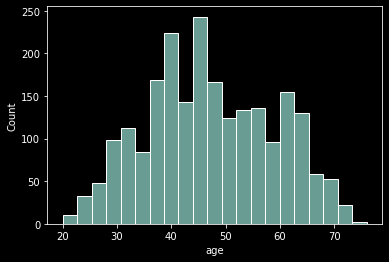

In [5]:
sns.histplot(customer_df['age']);

50세 정도를 기준으로 2개 그룹으로 나눌 수 있을 것 같다. 총 2240명 중 1120번째 고객의 나이를 확인해보고 약 절반을 나눌 수 있는 해당 나이대를 기준 값으로 선택한다.

In [14]:
customer_df['age'].sort_values()[:1120]

1170    20
46      20
2213    21
747     21
1850    21
        ..
1668    46
1477    46
36      46
2045    46
467     46
Name: age, Length: 1120, dtype: int64

46세 이하 고객을 A그룹, 46세가 넘는 고객을 B그룹에 포함시킬 수 있다. 

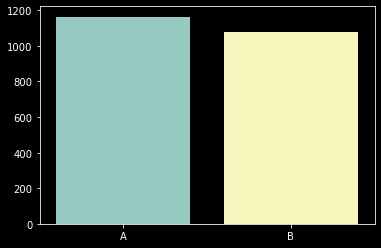

In [24]:
# 46세 이하 그룹은 A로, 46세 초과 그룹은 B로 표기하여 over_46이라는 새로운 변수에 담는다.
over_46 = customer_df['age'].apply(lambda x : 'A' if x <= 46 else 'B')

# A그룹에 몇명, B그룹에 몇명이 있는지에 대한 정보를 담은 시리즈 데이터를 counts_46에 담는다.
counts_46 = over_46.value_counts()
# counts_46의 인덱스(A, B)를 x축으로 하고 값(A,B 각각 갯수)을 y축에 표현한다.
sns.barplot(x=counts_46.index, y=counts_46.values);


### 1-2. 최근 구매일자에 따라 분류하기

<AxesSubplot:xlabel='day_f_buy', ylabel='Count'>

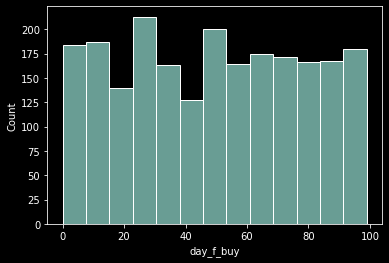

In [9]:
sns.histplot(customer_df['day_f_buy'])

### 1-3. 가입 기간에 따라 분류하기

<AxesSubplot:xlabel='period', ylabel='Count'>

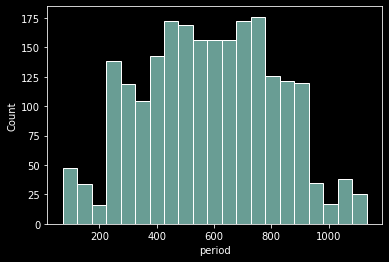

In [12]:
sns.histplot(customer_df['period'])

In [26]:
customer_df['complain'].value_counts()

0    2219
1      21
Name: complain, dtype: int64

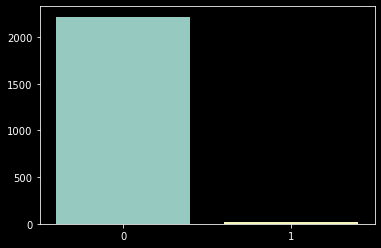

In [31]:
count_complain = customer_df['complain'].value_counts()

sns.barplot(x=count_complain.index, y=count_complain.values);

### 1-4. 온/오프라인 선호도에 따라 분류하기

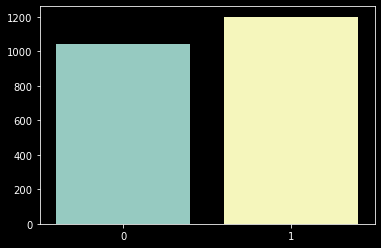

In [44]:
# 오프라인 노출 상품 구매 수 : 오프라인 매장 진열 상품 구매 수 + 전단지 노출 상품 구매 수
counts_buy_offline = customer_df['buy_f_store']+customer_df['buy_f_catalog']
# 온라인 노출 상품 구매 수 : 광고(프로모션) 상품 구매 수 + 웹사이트 표기 상품 구매 수
counts_buy_online = customer_df['buy_f_promo']+customer_df['buy_f_web']

# 오프라인 노출 상품을 온라인 노출 상품보다 많이 구매한 경우 True, 그렇지 않은 경우 False
s = counts_buy_offline > counts_buy_online
# True or False --> 1 or 0 으로 변환
s = s.astype(int)
customer_df['prefer_offline'] = s

# 1, 0 각각 카운트
count_offline = customer_df['prefer_offline'].value_counts()
# 시각화
sns.barplot(x=count_offline.index, y=count_offline.values);

### 1-5. 프로모션 동의 여부에 따라 분류하기

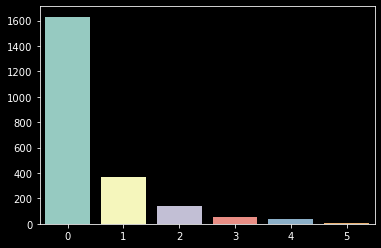

In [52]:
# 각 고객별 프로모션 동의 횟수 총합 계산 후 전체 동의 횟수 카운트
counts_check_promo = customer_df[['promo1','promo2','promo3','promo4','promo5','promo6']].sum(axis=1).value_counts()

# 시각화
sns.barplot(x=counts_check_promo.index, y=counts_check_promo.values);

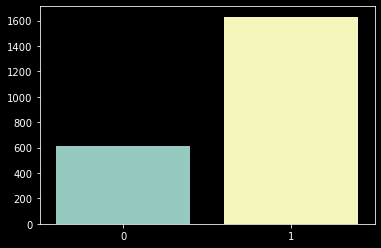

In [58]:
# 한번이라도 동의한사람
check_promo = customer_df[['promo1','promo2','promo3','promo4','promo5','promo6']].sum(axis=1)==0
check_promo = check_promo.astype(int)

count_check_promo_any = check_promo.value_counts()
# 시각화
sns.barplot(x=count_check_promo_any.index, y=count_check_promo_any.values);

In [27]:
test_df = customer_df[['day_f_buy','age','period']]
test_df

,day_f_buy,age,period
0,58,59,1042
1,38,62,196
2,26,51,543
3,26,32,136
4,94,35,392
...,...,...,...
2235,46,49,612
2236,56,70,132
2237,91,35,386
2238,8,60,387


In [30]:
model = DBSCAN(min_samples=2)
pred = model.fit_predict(test_df)
pred

array([-1, -1, -1, ..., -1, -1, -1])

In [33]:
pred.max()

201

### 1-6. 머신러닝으로 분류하기

In [ ]:
머신러닝 알고리즘은 K-Means(K평균)를 사용하겠다. K-Means 알고리즘은 우리가 특정한 K개 군집으로 

In [62]:
id = customer_df['id']
data = customer_df.iloc[:,1:]

In [76]:
kmeans = KMeans(n_clusters=2)

labels = kmeans.fit_predict(data)

<AxesSubplot:xlabel='period', ylabel='age'>

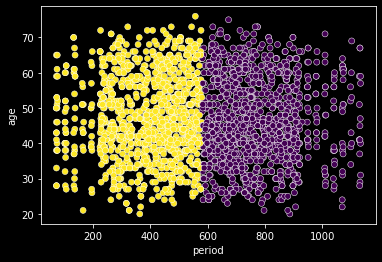

In [80]:
sns.scatterplot(data=data, x='period', y='age', c=labels)

클러스터는 'period'를 기준으로 그룹을 나눴다. 모든 데이터를 입력받았지만 결국 분류 기준을 period로 사용한 것이다.
확인을 위해 축을 변경해보면

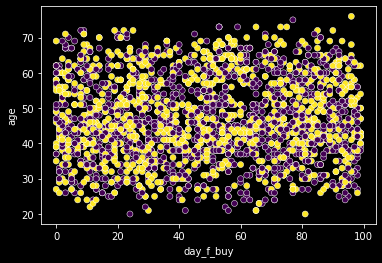

In [82]:
# 나이와 최근 구매일 정보로 시각화
sns.scatterplot(data=data, x='day_f_buy', y='age', c=labels);

period가 아닌 다른 연속형 변수 조합으로는 패턴을 찾을 수 없고,

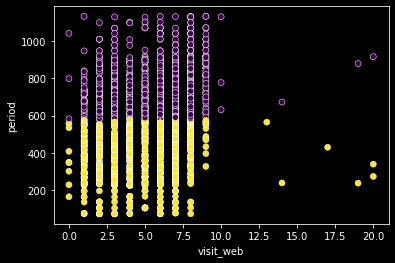

In [86]:
# 웹페이지 방문 수와 가입 기간 정보로 시각화
sns.scatterplot(data=data, x='visit_web', y='period', c=labels);

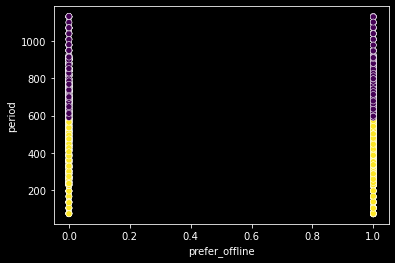

In [87]:
sns.scatterplot(data=data, x='prefer_offline', y='period', c=labels);

period를 축으로 세우면 다른 컬럼은 period를 기준으로 정확히 분류할 수 있다.

이렇게만 설명하면 머신러닝이 훨씬 편하고 좋은 방법인 것 같다. 하지만 또 다른 관점에서 보면 저런 패턴이 과연 사람이 찾기 어려운 패턴인가?에 대한 의문을 가질 수 있다. 이리 저리 뜯어봐도 그냥 period를 기준으로 절반 자른 것 같은 모양새다. 

사실, 이번 장에서는 적절하지 않은 머신러닝 사용이 해석에 오류를 가져오는 예를 보여주고 싶었다. 즉, 머신러닝을 사용하기 위해서는 데이터에 대한 이해가 굉장히 중요하며 이 말은, 즉 도메인을 이해한 채로 데이터를 분석해야 한다는 것을 의미하기도 한다.

머신러닝이 아무 데이터나 들이민다고 알아서 분류하고 예측하고 그룹을 묶어주는 것이 아니다. 어떤 기준으로 분류할지 먼저 정해야

In [35]:
customer_df

,id,day_f_buy,buy_f_promo,buy_f_web,buy_f_catalog,buy_f_store,visit_web,promo3,promo4,promo5,promo1,promo2,complain,promo6,age,period
0,5524,58,3,8,10,4,7,0,0,0,0,0,0,1,59,1042
1,2174,38,2,1,1,2,5,0,0,0,0,0,0,0,62,196
2,4141,26,1,8,2,10,4,0,0,0,0,0,0,0,51,543
3,6182,26,2,2,0,4,6,0,0,0,0,0,0,0,32,136
4,5324,94,5,5,3,6,5,0,0,0,0,0,0,0,35,392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,46,2,9,3,4,5,0,0,0,0,0,0,0,49,612
2236,4001,56,7,8,2,5,7,0,0,0,1,0,0,0,70,132
2237,7270,91,1,2,3,13,6,0,1,0,0,0,0,0,35,386
2238,8235,8,2,6,5,10,3,0,0,0,0,0,0,0,60,387


앞서 가정했다. 머신러닝을 직접 분석에 사용해본 적이 없고 글로만 접했다면 이상한 부분을 느끼지 못했을 것이다. 차원이 복잡하고 많아서 분석가가 해결하기 힘드니 머신러닝에게 맡기자! 라는 식으로 접근했다. 물론 결과는 비슷하게 나올 것이다. 머신러닝은 최적의 해를 찾기 때문에 우리가 분석 목적에 맞는 컬럼을 제대로 지정하고 해당 컬럼만 가지고 머신러닝을 진행하면 모든 차원을 고려한 머신러닝의 해와 거의 동일한 값이 나온다.

그런데 굳이 우리가 단계별로 해답을 찾아가야 하는 이유는 설명력을 확보하기 위해서다.

데이터 분석을 하는 이유는 설득과 설명, 주장의 근거를 확보하기 위해서다. 그런데 아 데이터 전부 넣고 기계를 돌려봤더니 이렇게 나왔어요' 라고 할 수는 없는 노릇이다.


이번에는 적절한 사용법을 알아보자

먼저 어떤 기준으로 고객을 분류할 것인지 분석가가 지정하고 시각화를 한다.

In [ ]:
다양한 기준으로 분석을 해볼 수 있겠지만, 우리는 연속형 변수만 가지고 분석을 해보겠다. 프로모션 동의 여부 등(prom)

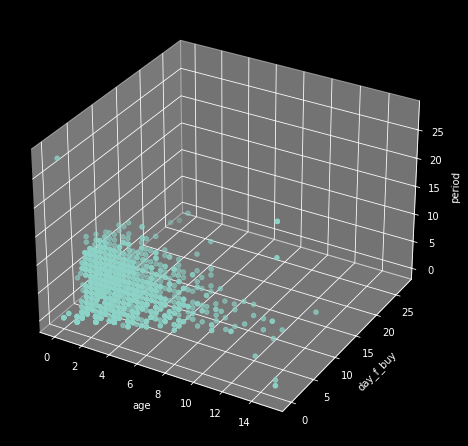

In [60]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.scatter(xs=customer_df['buy_f_promo'], ys=customer_df['buy_f_web'], zs=customer_df['buy_f_catalog'])
ax.set_xlabel('age')
ax.set_ylabel('day_f_buy')
ax.set_zlabel('period')
plt.show()

In [55]:
model = KMeans(n_clusters=2)
pred = model.fit_predict(customer_df[['buy_f_promo','buy_f_web','buy_f_catalog']])


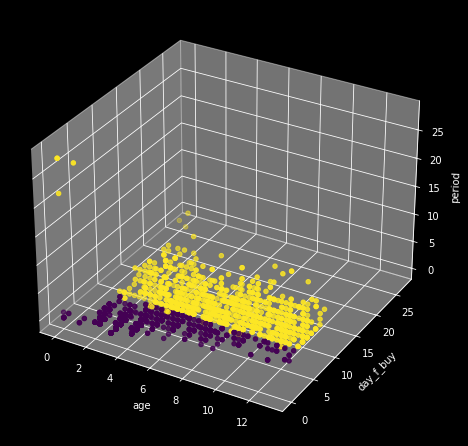

In [58]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.scatter(xs=customer_df['buy_f_store'], ys=customer_df['buy_f_web'], zs=customer_df['buy_f_catalog'], c=pred)
ax.set_xlabel('age')
ax.set_ylabel('day_f_buy')
ax.set_zlabel('period')
plt.show()

In [65]:
from sklearn.cluster import DBSCAN

model = DBSCAN(min_samples=60)
pred = model.fit_predict(customer_df[['age','day_f_buy','period']])


In [69]:
pred.sum()

-2240

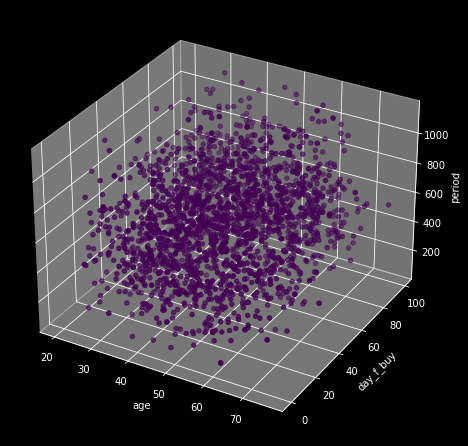

In [67]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.scatter(xs=customer_df['age'], ys=customer_df['day_f_buy'], zs=customer_df['period'], c=pred)
ax.set_xlabel('age')
ax.set_ylabel('day_f_buy')
ax.set_zlabel('period')
plt.show()

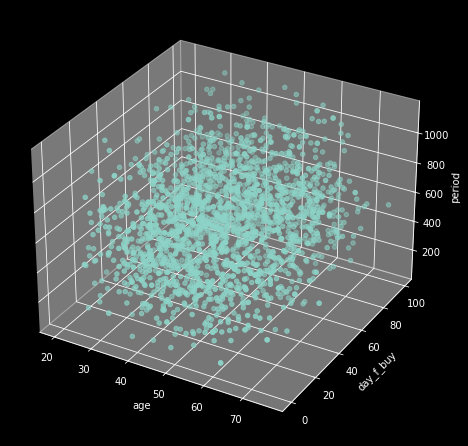

In [51]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.scatter(xs=customer_df['age'], ys=customer_df['day_f_buy'], zs=customer_df['period'])
ax.set_xlabel('age')
ax.set_ylabel('day_f_buy')
ax.set_zlabel('period')
plt.show()

In [47]:
model = KMeans(n_clusters=2)
pred = model.fit_predict(customer_df[['age','day_f_buy','period']])

In [41]:
ax.scatter(xs=customer_df['age'], ys=customer_df['day_f_buy'], zs=customer_df['period'], c = pred)

In [10]:
customer_df

,id,day_f_buy,buy_f_promo,buy_f_web,buy_f_catalog,buy_f_store,visit_web,promo3,promo4,promo5,promo1,promo2,complain,promo6,age,period
0,5524,58,3,8,10,4,7,0,0,0,0,0,0,1,59,1042
1,2174,38,2,1,1,2,5,0,0,0,0,0,0,0,62,196
2,4141,26,1,8,2,10,4,0,0,0,0,0,0,0,51,543
3,6182,26,2,2,0,4,6,0,0,0,0,0,0,0,32,136
4,5324,94,5,5,3,6,5,0,0,0,0,0,0,0,35,392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,46,2,9,3,4,5,0,0,0,0,0,0,0,49,612
2236,4001,56,7,8,2,5,7,0,0,0,1,0,0,0,70,132
2237,7270,91,1,2,3,13,6,0,1,0,0,0,0,0,35,386
2238,8235,8,2,6,5,10,3,0,0,0,0,0,0,0,60,387


In [11]:
model = DBSCAN()

In [12]:
labels = model.fit_predict(customer_df.iloc[:,1:])

<AxesSubplot:xlabel='day_f_buy', ylabel='period'>

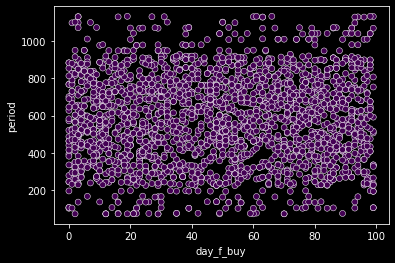

In [17]:
sns.scatterplot(data=customer_df, x='day_f_buy', y='period', c=labels)

<AxesSubplot:xlabel='buy_f_promo', ylabel='period'>

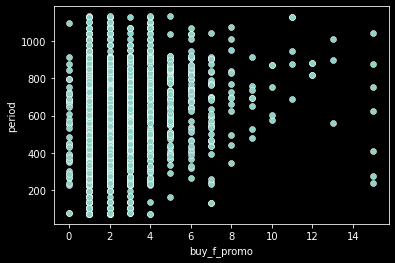

In [25]:
sns.scatterplot(data=customer_df, x='buy_f_promo', y='period')